In [25]:
! pip install numpy pandas ipywidgets tqdm PyQt6 scipy gymnasium "gymnasium[other]" "gymnasium[classic-control]"

Defaulting to user installation because normal site-packages is not writeable


#### Imports

In [26]:
from typing import Optional
import numpy as np
import gymnasium as gym
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
from IPython.display import display, clear_output
import copy
from scipy.ndimage import zoom
from tqdm.notebook import tqdm

N_EPISODES = 4000
UPDATE_STEP = 1     # Update q_values after each step
BETA = 0.5
ALPHA = 0.1
GAMMA = 0.9
SIZE = 30
STEPS = SIZE * SIZE

# TODO: Increase sensor ranger
# TODO: Lav pænere grafer
# TODO: Forstå boltzmann Beta
# TODO: Check om agent bliver rewarded istedet for penalized
# TODO: Dobbelt tjek Q-values
# TODO: Kører pyton noget multithreading?(Episode/sekund falder ikke ved træning af flere agenter?)

#### World class

In [27]:
class GridWorldEnv(gym.Env):

    def __init__(self, size: int = 10):
        # The size of the square grid
        self.size = size
        self.trajectory = []
        self.world = np.zeros((size, size)).T
        self.visited_states = np.zeros((size, size))


        # Define the agent and target location; randomly chosen in `reset` and updated in `step`
        self._agent_location = np.array([1, 1], dtype=np.int32)
        self._visited_states_near = np.zeros((3, 3))
        self._reward_near = np.zeros((3, 3))
        


        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        self.observation_space = gym.spaces.Dict(
            {
            "visited_states_near": gym.spaces.Box(-1, 1, shape=(3, 3), dtype=int),
            "reward_near": gym.spaces.Box(-1, 1, shape=(3, 3), dtype=int),
            }
        )

        # We have 8 actions, corresponding to "right", "up", "left", "down" and diagonal
        self.action_space = gym.spaces.Discrete(8)
        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
            4: np.array([1, 1]),  # up-right
            5: np.array([-1, 1]),  # up-left
            6: np.array([-1, -1]),  # down-left
            7: np.array([1, -1]),  # down-right
        }
    
    def normalize_env_reward(self):
        # Normalize the world to be between 0 and 1
        min_val = np.min(self.world)
        max_val = np.max(self.world)
        self.world = (self.world - min_val) / (max_val - min_val)

    def scale_env(self):
        # Scale all rewards to be between 0 and 10
        min_val = np.min(self.world)
        max_val = np.max(self.world)
        self.world = (self.world - min_val) / (max_val - min_val) * 10
        self.world = np.round(self.world, 0)


    def random_env(self):
        self.world = np.random.randint(1, 11, size=(self.size, self.size))

    def heatmap_env(self):
        with open("../Kaspers_chad_pdfer_mm/heatmap/data/heatmap.pkl", "rb") as f:
            heatmap = np.rot90(pickle.load(f), k=1)
        
        heatmap_scaled = zoom(heatmap, (self.size / heatmap.shape[0], self.size / heatmap.shape[1]), order=1)  # Bilinear interpolation

        self.world = heatmap_scaled
        # self.normalize_env_reward()
        self.scale_env()
    
    def reset_visited_states(self):
        self.visited_states = np.zeros((self.size, self.size))
    
    def world_from_matrix(self, matrix):
        self.world = matrix

    def setReward(self, x, y , reward):
        self.world[x][y] = reward

    def _get_info(self):
        return {
            "agent_location": self._agent_location
        }

    def _get_obs(self):
        return {
            "visited_states_near": self._visited_states_near,
            "reward_near": self._reward_near,
        }


    def reset(self, agents, seed: Optional[int] = None, options: Optional[dict] = None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        for agent in agents:
            agent.location = self.np_random.integers(0, self.size -1, size=2, dtype=int)
        
        # reset visited states near and reward_near
        self._visited_states_near = np.zeros((3, 3))
        self._reward_near = np.zeros((3, 3))


        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def getReward(self):
        return self.world[self._agent_location[0], self._agent_location[1]]


    def check_rewards_near(self):
        x, y = self._agent_location
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.size and 0 <= ny < self.size:
                    self._reward_near[dx + 1, dy + 1] = self.world[nx][ny]

    def check_visited_near(self):
        # Create a 3x3 local view centered on the agent
        x, y = self._agent_location

        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.size and 0 <= ny < self.size:
                    self._visited_states_near[dx + 1, dy + 1] = self.visited_states[nx][ny]


    def step(self, action):
        # Map the action (element of {0,1,2,3,4,5,6,7}) to the direction we walk in
        direction = self._action_to_direction[action]


        # We use `np.clip` to make sure we don't leave the grid bounds
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )

         # --- Update `visited_states` ---
        grid_x, grid_y = self._agent_location
        self.visited_states[grid_x][grid_y] = 1

        self.check_rewards_near()
        self.check_visited_near()



        # An environment is completed if and only if the agent has searched all states
        terminated = False
        truncated = False
        reward = self.getReward()
        observation = self._get_obs()
        info = self._get_info()

        

        return observation, reward, terminated, truncated, info
    
    

#### Agent Class
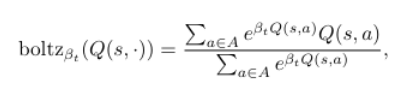

In [28]:
class SAR_agent:
    def __init__(
        self,
        agent_id,
        env: gym.Env,
        alpha: float,
        beta,
        gamma: float = 0.
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            gamma: The discount factor for computing the Q-value
        """
        self.agent_id = agent_id
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.location = np.array([-1, -1], dtype=np.int32)

        self.alpha = alpha
        self.gamma = gamma

        self.beta = beta
        self.trajectory = []

        self.training_error = []

    def reset_trajectory(self):
        self.trajectory = []

    def add_trajectory(self):
        self.trajectory.append(self.location)


    def get_action(self, obs: dict, step) -> int:
        visited_states_near = obs["visited_states_near"]
        reward_near = obs["reward_near"]

        # Flatten the arrays and convert them into a hashable tuple
        agent_state = tuple(visited_states_near.flatten()) + tuple(reward_near.flatten())

        # Create a directional bias from reward_near
        action_bias = np.zeros(self.env.action_space.n)



        q_values = self.q_values[agent_state]
        exp_q = np.exp(self.beta * q_values - np.max(self.beta * q_values))  

        # Normalize Q-values using Boltzmann
        boltzmann_probs = exp_q / np.sum(exp_q)

        # Calculate bias for each action based on nearby rewards
        for action, (dx, dy) in self.env._action_to_direction.items():
            bias_x, bias_y = dx + 1, dy + 1 
            action_bias[action] = max(0, reward_near[bias_x, bias_y]) 

        # Normalize bias (avoid division by zero)
        if np.max(action_bias) > 0:
            action_bias = action_bias / (np.max(action_bias) + 1e-5)

        # Adjust probabilities: mix Boltzmann probabilities with bias
        adjusted_probs = boltzmann_probs + 0.1 * action_bias  

        # **Ensure probabilities are non-negative and sum to 1**
        adjusted_probs = np.maximum(adjusted_probs, 0) 
        adjusted_probs /= np.sum(adjusted_probs)  

        return np.random.choice(len(q_values), p=adjusted_probs)





    def update(
        self,
        obs: dict,  
        action: int,
        reward: float,
        terminated: bool,
        next_obs: dict,  
    ):
        # Extract agent's position and convert to tuple (ensuring it's hashable)
        # Extract features from observations
        visited_states_near = obs["visited_states_near"]
        reward_near = obs["reward_near"]

        # Flatten the arrays and convert them into a hashable tuple
        agent_state = tuple(visited_states_near.flatten()) + tuple(reward_near.flatten())
        next_agent_state = tuple(next_obs["visited_states_near"].flatten()) + tuple(next_obs["reward_near"].flatten())

        # Compute future Q-value using the Boltzmann policy if the episode is not terminated
        if not terminated:
            exp_q_next = np.exp(self.beta * self.q_values[next_agent_state] - np.max(self.beta * self.q_values[next_agent_state]))
            boltz_q = np.sum(exp_q_next * self.q_values[next_agent_state]) / np.sum(exp_q_next)  # Boltzmann-weighted sum of Q-values
     

        # Compute the Temporal Difference (TD) error
        temporal_difference = (
            reward + self.gamma * boltz_q - self.q_values[agent_state][action]
        )


        # Update the Q-value using the learning rate and the TD error
        self.q_values[agent_state][action] += self.alpha * temporal_difference

        # Track the training error for logging or debugging
        self.training_error.append(temporal_difference)




    def plot_trajectory(self, time_step):
        """Animate the agent's trajectory on a grid."""
        plt.figure()  # Create a figure
        for i, state in enumerate(self.trajectory):
            clear_output(wait=True)  # Clears the previous plot
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.title("Agent's Trajectory Simulation")
            plt.grid(True)
            
            # Plot all previous points in blue
            past_x, past_y = zip(*self.trajectory[: i + 1])  # Get all visited points
            plt.plot(past_x, past_y, "bo-", label="Past Path")  # Blue path
            
            # Plot current point in red
            plt.plot(state[0], state[1], "ro", markersize=10, label="Current Position")
            
            plt.legend()
            plt.xlim(-1, self.env.size + 1)  # Set limits to prevent resizing
            plt.ylim(-1, self.env.size + 1)
            plt.pause(time_step)  # Pause for animation
        
        plt.show()  # Keep the final plot displayed
        



#### Swarm Class

In [29]:
class swarm:
    def __init__(self, env, agents, n_episodes, update_step=1):
        self.env = env
        self.agents = agents
        self.visited_states = [[0 for _ in range(env.size)] for _ in range(env.size)]
        self.cum_reward = []    # :TODO overvej nyt navn
        self.episode_cum_reward = [0 for _ in range(N_EPISODES)]
        self.n_episodes = n_episodes
        self.coverage_pr_episode = []
        self.revisits = []
        self.info_pr_episode = []
        self.update_step = update_step

    #writes to visited states
    def state_visited(self, obs):
        x, y = obs['agent']
        self.visited_states[y][x] += 1  # mark as visited

    #reads from visited states
    def state_has_been_visited(self, obs):
        x, y = obs['agent']
        return self.visited_states[y][x] == 1

    def reset_trajectory(self):
        for agent in self.agents:
            agent.reset_trajectory()

    def coverage_performance(self, train_env):
        covered = 0
        for i in range(train_env.size):
            for j in range(train_env.size):
                if train_env.visited_states[i][j] != 0:
                    covered += 1
        cover_percent = (covered / (train_env.size * train_env.size)) * 100
        self.coverage_pr_episode.append(cover_percent)

    def calc_revisits(self, train_env):
        revisited = 0
        for i in range(train_env.size):
            for j in range(train_env.size):
                if train_env.visited_states[i][j] == 1:
                    revisited += train_env.visited_states[i][j]
        self.revisits.append(revisited)

    def calc_info(self, train_env):
        visited_rewards = 0
        for i in range(train_env.size):
            for j in range(train_env.size):
                visited_rewards += self.env.world[i][j] * train_env.visited_states[i][j]

    
        total_rewards = np.sum(self.env.world)
        
        self.info_pr_episode.append(visited_rewards / total_rewards)


    def train_swarm(self, max_steps):
        # Use tqdm.notebook for a cleaner progress bar in Jupyter
        progress_bar = tqdm(range(self.n_episodes), desc="Training Progress", unit="episode", leave=False)

        for episode in progress_bar:
            train_env = copy.deepcopy(self.env)
            progress_bar.set_description(f"Training Progress (Episode {episode + 1}/{self.n_episodes})")

            # Reset the environment for the start of the episode
            obs, info = train_env.reset(self.agents)
            self.reset_trajectory()
            train_env.reset_visited_states()
            self.cum_reward = 0
            terminated = False
            steps = 0
            done = False

            # Run the episode until termination
            while not done:
                for agent in self.agents:
                    x, y = info['agent_location']
                    action = agent.get_action(obs, steps)

                    # Take a step in the environment
                    next_obs, reward, terminated, truncated, info = train_env.step(action)
                    agent.location = info['agent_location']

                    if(steps % self.update_step == 0):
                        agent.update(obs, action, reward, terminated, next_obs)

                    agent.add_trajectory()
                    self.episode_cum_reward[episode] += reward
                    train_env.setReward(x, y, -0.3)

                    if steps >= max_steps:
                        terminated = True

                    done = terminated or truncated
                    obs = next_obs
                    steps += 1

            self.episode_cum_reward.append(self.cum_reward)
            self.coverage_performance(train_env)
            self.calc_revisits(train_env)
            self.calc_info(train_env)

        # Ensure the last progress bar is cleared at the end
        progress_bar.close()


    def plot_reward_episode(self):
        """"Plots reward per episode"""
        plt.figure()
        x = range(self.n_episodes)
        y = self.episode_cum_reward[:self.n_episodes]

        plt.plot(x, y)
        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.title('Reward per Episode')
        plt.show()

    def plot_coverage_perfomance(self):
        """"Plots reward per episode"""
        plt.figure()
        x = range(self.n_episodes)
        y = self.coverage_pr_episode[:self.n_episodes]

        plt.plot(x, y)
        plt.xlabel('Episodes')
        plt.ylabel('Coverage')
        plt.title('Coverage per Episode')
        plt.show()
        
    def plot_revisited(self):
        """"Plots revisits per episode"""
        plt.figure()
        x = range(self.n_episodes)
        y = self.revisits[:self.n_episodes] 

        plt.plot(x, y)
        plt.xlabel('Episodes')
        plt.ylabel('Revisits')
        plt.title('Revisits per Episode')
        plt.show()

    def plot_info(self):
        """"Plots revisits per episode"""
        plt.figure()
        x = range(self.n_episodes)
        y = self.info_pr_episode[:self.n_episodes] 

        plt.plot(x, y)
        plt.xlabel('Episodes')
        plt.ylabel('Info')
        plt.title('Info gain per Episode')
        plt.show()
    
    def plot_trajectories(self):
        # Static plot of all agent trajectories in different colors
        plt.figure()
        for agent in self.agents:
            trajectory = np.array(agent.trajectory)
            plt.plot(trajectory[:, 0], trajectory[:, 1], label="Agent %s Trajectory" % agent.agent_id)

        plt.xlim(-1, self.env.size + 1)  # Set limits to prevent resizing
        plt.ylim(-1, self.env.size + 1)

        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Agent Trajectories")
        plt.legend()
        plt.show()

### Hyperparameters

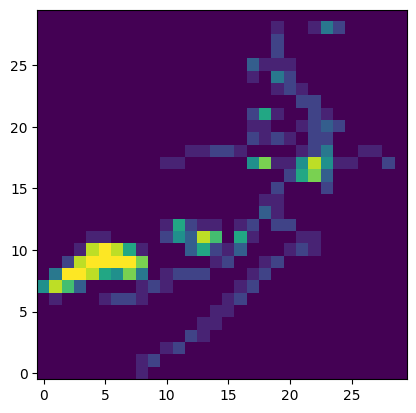

  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.

In [30]:
# hyperparameters

env = GridWorldEnv(size=SIZE)

env.heatmap_env()

plt.imshow(env.world, cmap='viridis')
plt.gca().invert_yaxis()
plt.show()
# Print the environment world matrix in a pretty format
for row in env.world:
    print(" ".join(f"{val:5.1f}" for val in row))

env_timelimit = gym.wrappers.TimeLimit(env, max_episode_steps=1000)

agent = SAR_agent(
    0,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    gamma=GAMMA
)

agent1 = SAR_agent(
    1,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    gamma=GAMMA
)

agent2 = SAR_agent(
    2,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    gamma=GAMMA
)

agent3 = SAR_agent(
    3,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    gamma=GAMMA
)

agent4 = SAR_agent(
    4,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    gamma=GAMMA
)

agents = []
agents.append(agent)
# agents.append(agent1)
# agents.append(agent2)
# agents.append(agent3)
# agents.append(agent4)

In [31]:
swarm = swarm(env, agents, N_EPISODES, UPDATE_STEP)

swarm.train_swarm(STEPS)

Training Progress:   0%|          | 0/4000 [00:00<?, ?episode/s]

KeyboardInterrupt: 

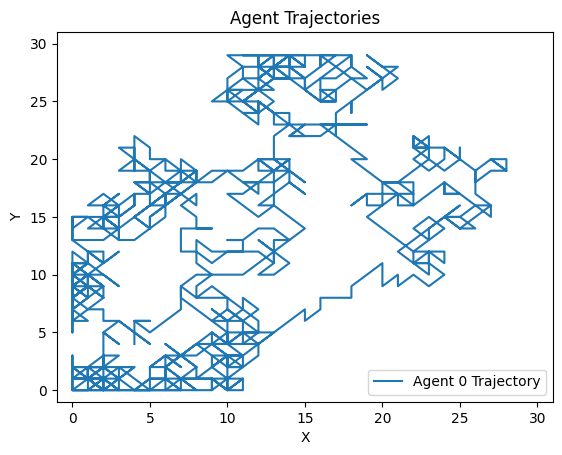

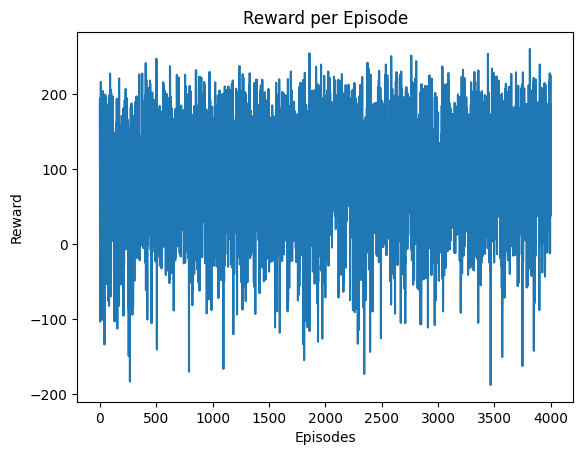

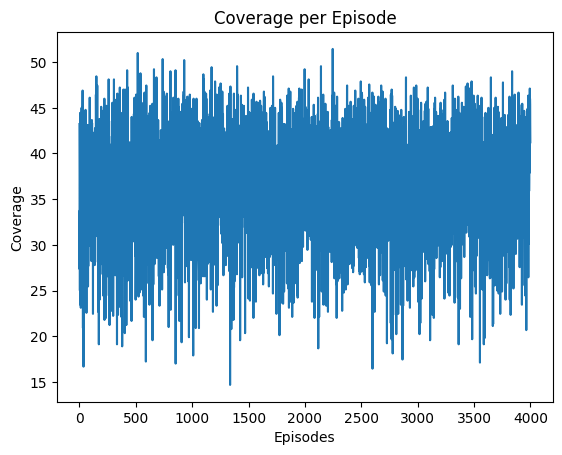

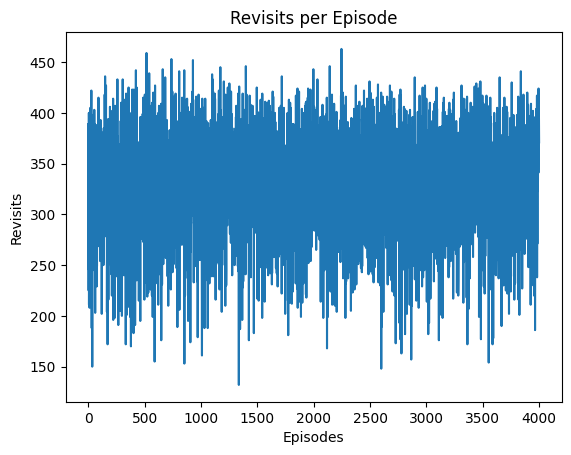

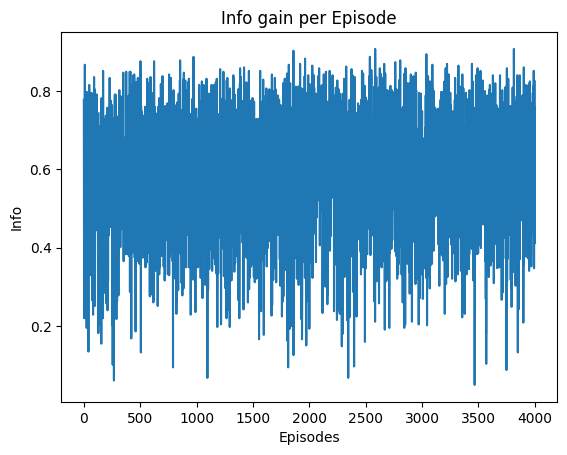

In [ ]:
swarm.plot_trajectories()
swarm.plot_reward_episode()
swarm.plot_coverage_perfomance()
swarm.plot_revisited()
swarm.plot_info()
# print(agents[0].q_values)

In [ ]:
agents[0].plot_trajectory(0.05)



KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>